In [31]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import random

# Configuración inicial
height = 150
width = 150
batch_size = 64
seed = 100

# Asegurar reproducibilidad
torch.manual_seed(seed)
random.seed(seed)

# Ruta principal del dataset
dataset_path = "./MY_data"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
predict_path = os.path.join(dataset_path, "predict")

# Asegurarse de que el dispositivo CUDA esté configurado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

# Verificar si el dataset ya está descargado
if not os.path.exists(train_path) or not os.path.exists(test_path) or not os.path.exists(predict_path):
    print("Dataset no encontrado, descargando...")
    os.system("kaggle datasets download -d karimabdulnabi/fruit-classification10-class -p ./ --unzip")
    print(f"Dataset descargado en: {dataset_path}")
else:
    print("El dataset ya está descargado.")

Usando: cuda
El dataset ya está descargado.


In [52]:
import os
from torchvision.datasets import ImageFolder
from collections import Counter


# Cargar datasets
train_data = ImageFolder(root=train_path)
test_data = ImageFolder(root=test_path)

# Contar imágenes por clase en el conjunto de entrenamiento
train_classes = [label for _, label in train_data.samples]
train_counts = Counter(train_classes)

# Contar imágenes por clase en el conjunto de prueba
test_classes = [label for _, label in test_data.samples]
test_counts = Counter(test_classes)

# Imprimir resultados
print("Número de imágenes por clase en el conjunto de entrenamiento:")
for class_idx, count in train_counts.items():
    print(f"Clase {train_data.classes[class_idx]}: {count} imágenes")

print("\nNúmero de imágenes por clase en el conjunto de prueba:")
for class_idx, count in test_counts.items():
    print(f"Clase {test_data.classes[class_idx]}: {count} imágenes")


Número de imágenes por clase en el conjunto de entrenamiento:
Clase Apple: 301 imágenes
Clase Banana: 323 imágenes
Clase avocado: 300 imágenes
Clase cherry: 326 imágenes
Clase kiwi: 322 imágenes
Clase mango: 303 imágenes
Clase orange: 303 imágenes
Clase pinenapple: 283 imágenes
Clase strawberries: 299 imágenes
Clase watermelon: 305 imágenes

Número de imágenes por clase en el conjunto de prueba:
Clase apple: 59 imágenes
Clase avocado: 35 imágenes
Clase banana: 53 imágenes
Clase cherry: 49 imágenes
Clase kiwi: 53 imágenes
Clase mango: 72 imágenes
Clase orange: 64 imágenes
Clase pinenapple: 67 imágenes
Clase stawberries: 74 imágenes
Clase watermelon: 34 imágenes


Usando: cuda
Epoch 1/10, Train Loss: 1.4857, Train Accuracy: 64.86%, Validation Loss: 0.3948, Validation Accuracy: 89.37%
Mejor modelo guardado.
Epoch 2/10, Train Loss: 0.4291, Train Accuracy: 88.55%, Validation Loss: 0.2510, Validation Accuracy: 91.99%
Mejor modelo guardado.
Epoch 3/10, Train Loss: 0.2499, Train Accuracy: 92.95%, Validation Loss: 0.2231, Validation Accuracy: 93.38%
Mejor modelo guardado.
Epoch 4/10, Train Loss: 0.2111, Train Accuracy: 93.64%, Validation Loss: 0.1852, Validation Accuracy: 93.90%
Mejor modelo guardado.
Epoch 5/10, Train Loss: 0.1747, Train Accuracy: 94.85%, Validation Loss: 0.1702, Validation Accuracy: 95.12%
Mejor modelo guardado.
Epoch 6/10, Train Loss: 0.1614, Train Accuracy: 94.98%, Validation Loss: 0.1756, Validation Accuracy: 93.90%
No se ha encontrado un mejor modelo en 1 épocas consecutivas.
Epoch 7/10, Train Loss: 0.1480, Train Accuracy: 95.69%, Validation Loss: 0.1674, Validation Accuracy: 95.64%
Mejor modelo guardado.
Epoch 8/10, Train Loss: 

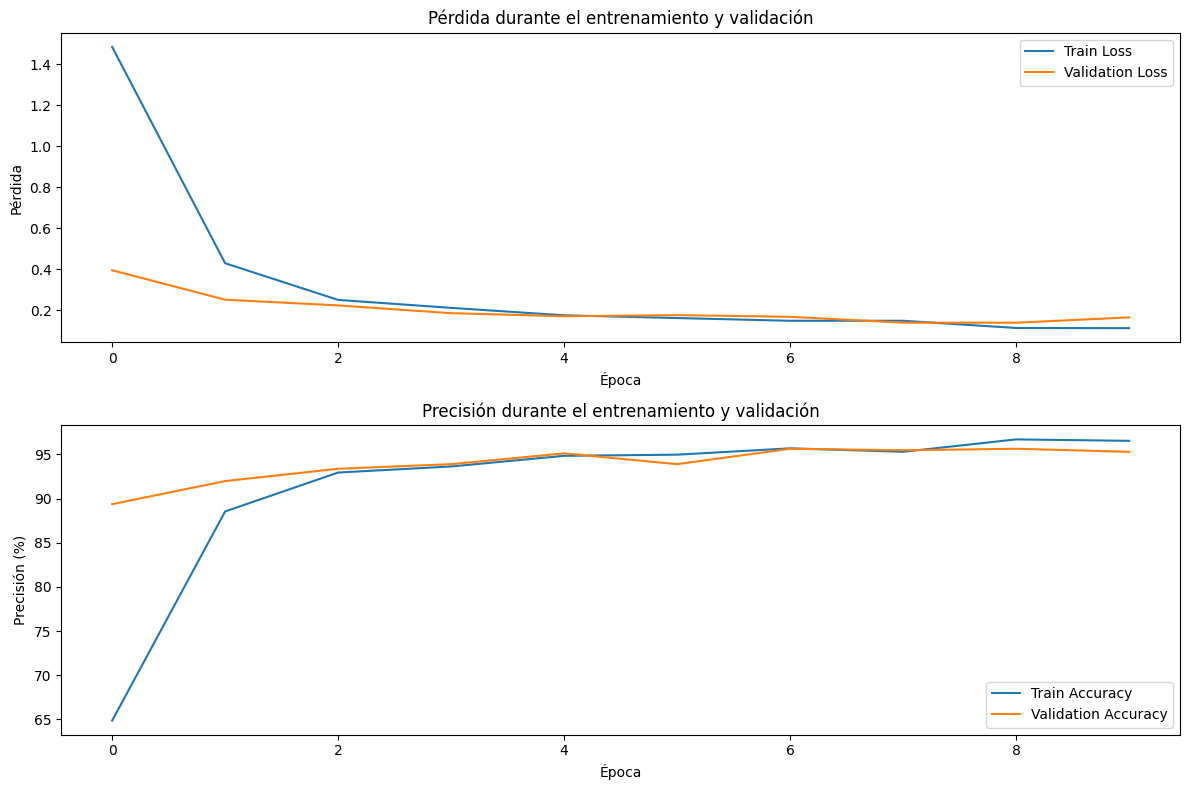

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# Configuración inicial
height, width = 224, 224  # Tamaño compatible con ResNet18
batch_size = 64
num_classes = 10  # Cambia esto según el número de clases en tu dataset
seed = 100

# Asegurar reproducibilidad
torch.manual_seed(seed)

# Dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

# Transformaciones para imágenes (escalado, normalización)
transform = transforms.Compose([
    transforms.Resize((height, width)),  # Cambia el tamaño de las imágenes
    transforms.ToTensor(),               # Convierte las imágenes a tensores
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Aumentación de datos
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((height, width)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# Cargar datasets
train_data = ImageFolder(root=train_path, transform=transform_train)
test_data = ImageFolder(root=test_path, transform=transform)
# DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Cargar modelo preentrenado
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Configuración de entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Listas para registrar métricas
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Variables para el control del mejor modelo
best_val_loss = float('inf')
patience = 5
trigger_times = 0

# Entrenamiento
epochs = 10
for epoch in range(epochs):
    # Modo de entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Modo de validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    scheduler.step(val_loss)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Guardar el mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Mejor modelo guardado.")
    else:
        trigger_times += 1
        print(f"No se ha encontrado un mejor modelo en {trigger_times} épocas consecutivas.")
        if trigger_times >= patience:
            print("Detención temprana activada.")
            break

# Graficar las métricas
plt.figure(figsize=(12, 8))

# Gráfica de pérdida
plt.subplot(2, 1, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Pérdida durante el entrenamiento y validación")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

# Gráfica de precisión
plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Precisión durante el entrenamiento y validación")
plt.xlabel("Época")
plt.ylabel("Precisión (%)")
plt.legend()

plt.tight_layout()
plt.show()

Accuracy of the model on the test images: 95.30%


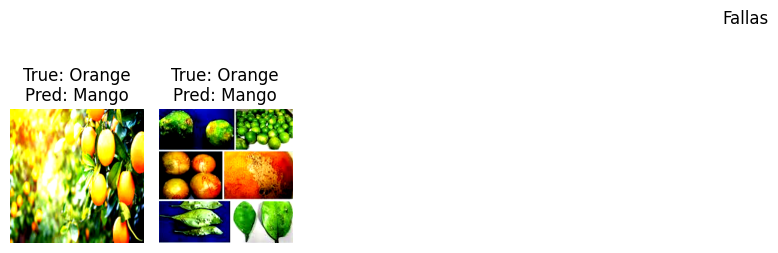

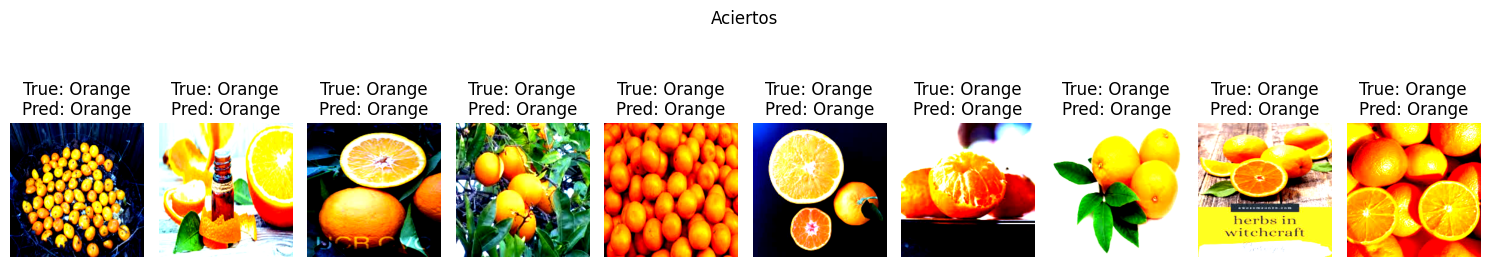

In [68]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

species_to_check = 6  # * Cambiar número al índice de la clase que se desee verificar
class_names = ['Apple', 'Avocado', 'Banana', 'Cherry', 'Kiwi', 'Mango', 'Orange', 'Pineapple', 'StrawBerries', 'Watermelon']

# Mover el modelo a la GPU si es necesario
model = model.to(device)

correct = 0
total = 0

# Listas para almacenar imágenes que fallaron y aciertos
results = {
    "failed": [],
    "correct": []
}

# Colocar el modelo en modo evaluación
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Obtener las predicciones
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Almacenar imágenes según resultado
        for i in range(len(labels)):
            if labels[i].item() == species_to_check:  # Verifica si corresponde a la especie seleccionada
                if predicted[i] != labels[i]:
                    results["failed"].append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))
                else:
                    results["correct"].append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

# Verificar que total no sea cero
if total > 0:
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')
else:
    print('No test images found.')

# Mostrar imágenes que fallaron y acertaron
def show_images(images, titles, num_to_display=10, title=''):
    plt.figure(figsize=(15, 6))
    for i in range(min(num_to_display, len(images))):
        plt.subplot(2, 10, i + 1)
        
        # Normalizar la imagen a [0, 1]
        image = images[i]
        image = (image + 1) / 2  # Normalizar de [-1, 1] a [0, 1]
        image = torch.clamp(image, 0, 1)  # Clipping to the valid range [0, 1]

        # Mostrar imágenes a color
        plt.imshow(image.permute(1, 2, 0))  # Cambiar el orden de dimensiones de CxHxW a HxWxC
        plt.title(titles[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Mostrar imágenes que fallaron
if results["failed"]:
    failed_images, failed_labels, failed_predictions = zip(*results["failed"])
    show_images(failed_images, 
                [f'True: {class_names[l.item()]}\nPred: {class_names[p.item()]}' for l, p in zip(failed_labels, failed_predictions)], 
                title='Fallas')
else:
    print("No se encontraron imágenes que fallaron.")

# Mostrar imágenes que acertaron
if results["correct"]:
    correct_images, correct_labels, correct_predictions = zip(*results["correct"])
    show_images(correct_images, 
                [f'True: {class_names[l.item()]}\nPred: {class_names[p.item()]}' for l, p in zip(correct_labels, correct_predictions)], 
                title='Aciertos')
else:
    print("No se encontraron imágenes que acertaron.")


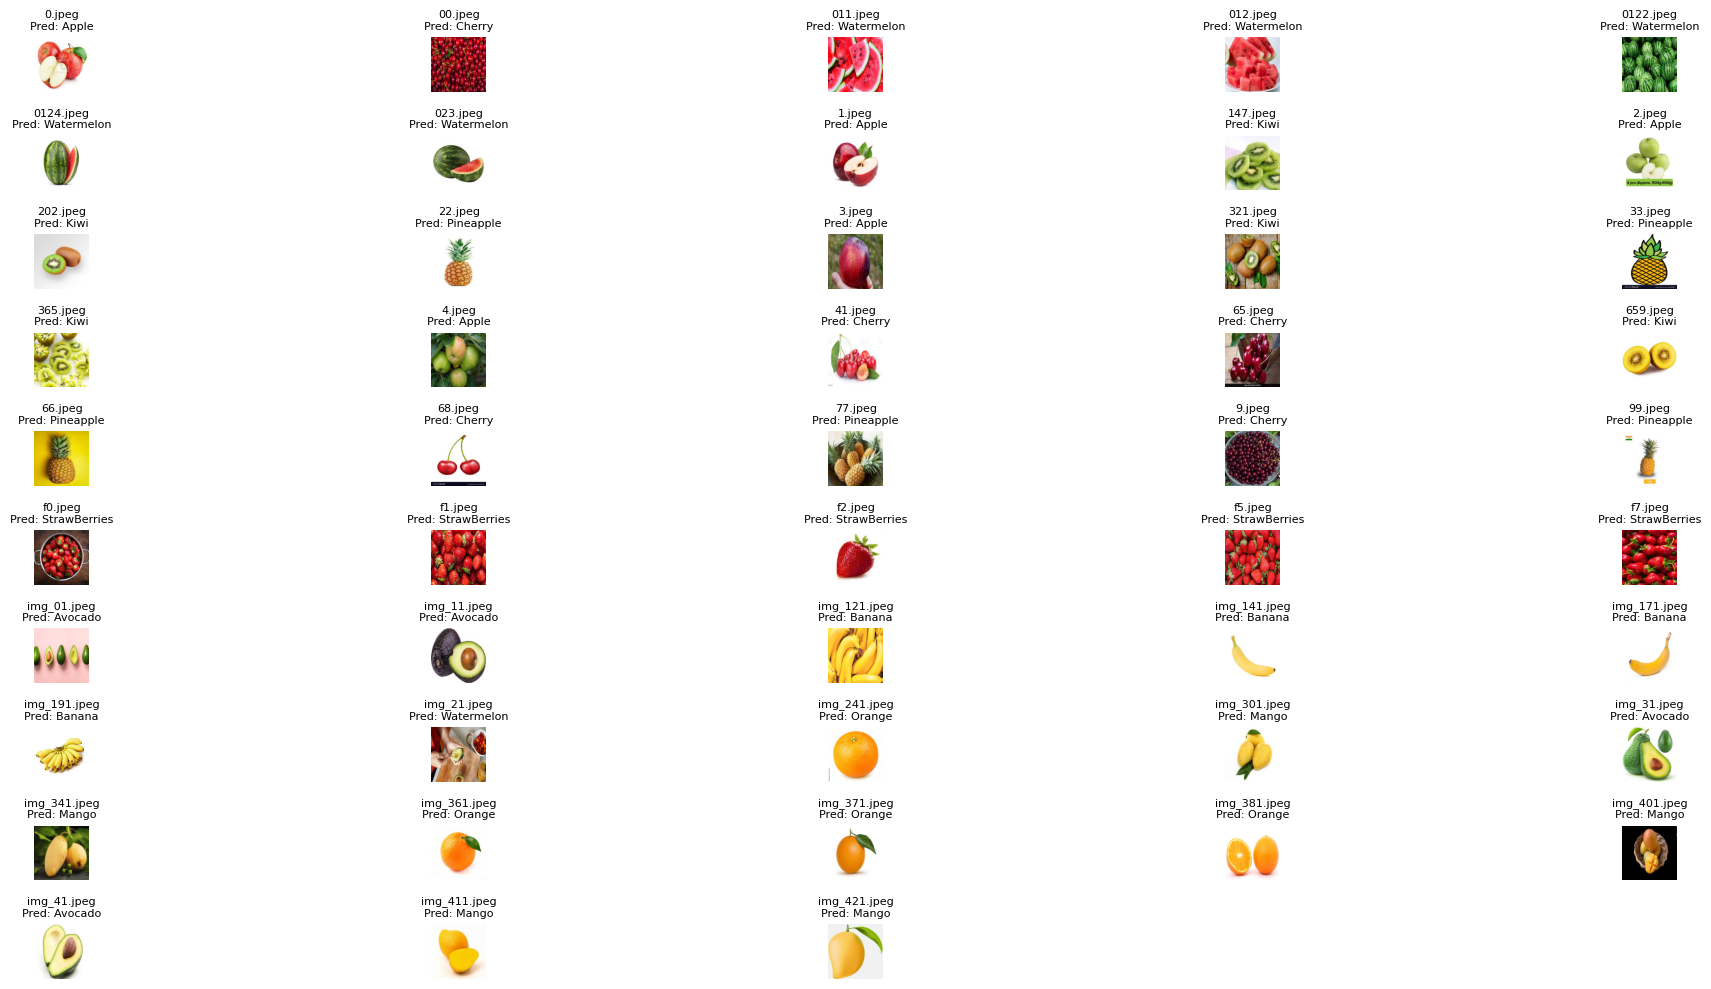

In [62]:
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Transformación que se usó para entrenar el modelo
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajusta el tamaño según tu modelo
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Igual que en el entrenamiento
])

# Cargar imágenes de la carpeta
images = []
image_paths = []
for file_name in sorted(os.listdir(predict_path)):
    file_path = os.path.join(predict_path, file_name)
    if file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
        image = Image.open(file_path).convert('RGB')
        images.append(transform(image))
        image_paths.append(file_name)

# Convertir las imágenes a un tensor de batch
images_tensor = torch.stack(images).to(device)

# Colocar el modelo en modo evaluación
model.eval()

# Obtener predicciones
with torch.no_grad():
    outputs = model(images_tensor)
    _, predictions = torch.max(outputs, 1)

# Visualizar imágenes con sus predicciones
def show_predictions(images, predictions, image_paths, class_names):
    num_to_display = len(images)  # Mostrar todas las imágenes
    plt.figure(figsize=(20, 10))
    for i in range(num_to_display):
        plt.subplot((num_to_display + 4) // 5, 5, i + 1)  # Ajustar el layout para que quepan todas
        
        # Desnormalizar para mostrar correctamente
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = images[i].cpu() * std + mean
        
        # Asegurarse de que los valores estén entre 0 y 1
        plt.imshow(image.permute(1, 2, 0).clip(0, 1))
        plt.title(f'{image_paths[i]}\nPred: {class_names[predictions[i].item()]}', fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Asume que tienes un diccionario o lista `class_names` con los nombres de las clases
show_predictions(images, predictions, image_paths, class_names)


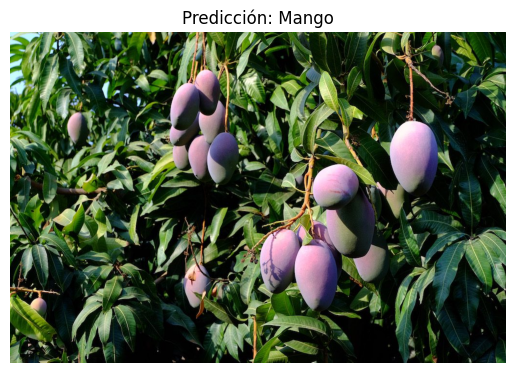

In [65]:
from io import BytesIO
import requests
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Transformación que se usó para entrenar el modelo
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajusta el tamaño según tu modelo
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Igual que en el entrenamiento
])

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

def predict_image(url, model, class_names):
    # Cargar imagen desde la URL
    image = load_image_from_url(url)

    # Aplicar la transformación
    image_tensor = transform(image).unsqueeze(0).to(device)  # Añadir una dimensión para el batch

    # Colocar el modelo en modo evaluación
    model.eval()

    # Obtener predicciones
    with torch.no_grad():
        outputs = model(image_tensor)
        _, prediction = torch.max(outputs, 1)

    # Mostrar la imagen y la predicción
    plt.imshow(image)
    plt.title(f'Predicción: {class_names[prediction.item()]}')
    plt.axis('off')
    plt.show()

# Ejemplo de uso
url = 'https://exoticfruitbox.com/wp-content/uploads/2015/10/DSCF0529-1024x683.jpg'  # Reemplaza con la URL de la imagen que deseas cargar
class_names = ['Apple', 'Avocado', 'Banana', 'Cherry', 'Kiwi', 'Mango', 'Orange', 'Pineapple', 'StrawBerries', 'Watermelon']  # Actualiza con tus clases
predict_image(url, model, class_names)


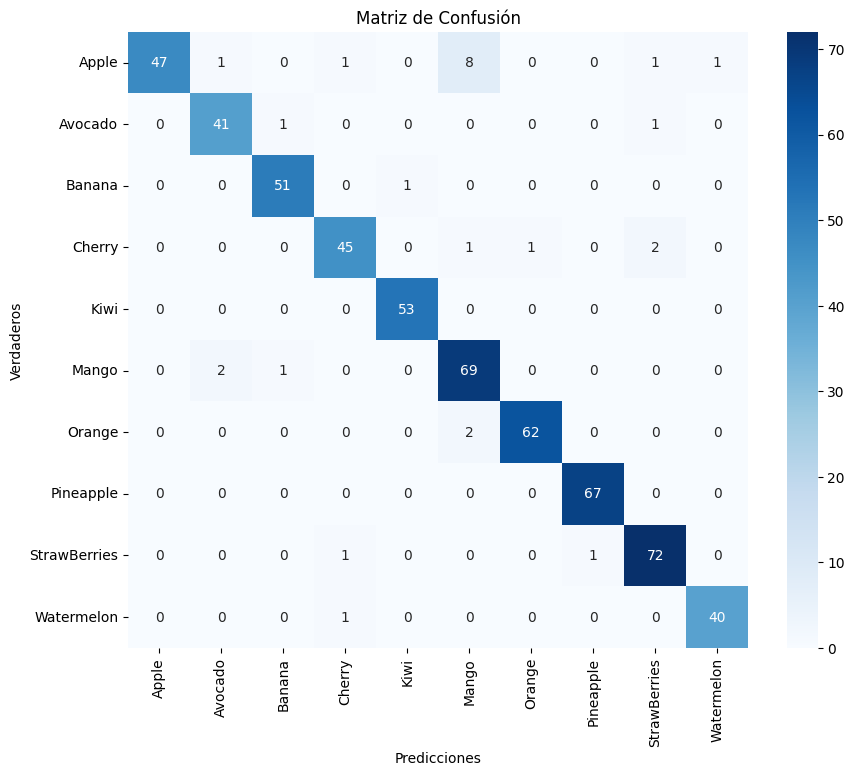

In [69]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_labels = []
all_predictions = []

# Colocar el modelo en modo evaluación
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Obtener las predicciones
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_predictions)

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()
